# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


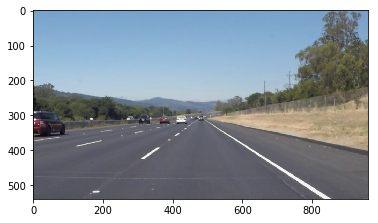

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [9]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
   

def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    x_left=[]
    y_left=[]
    x_right=[]
    y_right=[]
    x1_none=[]
    x2_none=[]
    y1_none=[]
    y2_none=[]
    y_roi = [320, 540]
    line_img1 = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if abs(slope) < .5:
                x1_none.append(x1)
                x2_none.append(x2)
                y1_none.append(y1)
                y2_none.append(y2)
            
            elif x1 <= 500 and x2 <= 500 :
                x_left.append(x1)
                x_left.append(x2)
                y_left.append(y1)
                y_left.append(y2)
            else :
                x_right.append(x1)
                x_right.append(x2)
                y_right.append(y1)
                y_right.append(y2)
                
    #y_left                
    left_fit = np.polyfit(x_left, y_left,1)
    right_fit = np.polyfit(x_right, y_right,1)
                
    #Left lane
    m_left = left_fit[0]
    b_left = left_fit[1]

    minleft_x = min(x_left)
    maxleft_x = max(x_left)

    minleft_y = m_left*minleft_x + b_left
    maxleft_y = m_left*maxleft_x + b_left

    point_1x = int(minleft_x)
    point_1y = int(minleft_y)
    point_2x = int(maxleft_x)
    point_2y = int(maxleft_y)
    
    cv2.line(img, (point_1x, point_1y), (point_2x, point_2y), color,thickness)                

    #Right lane
    m_right = right_fit[0]
    b_right = right_fit[1]

    minright_x = min(x_right)
    maxright_x = max(x_right)

    minright_y = m_right*minright_x + b_right
    maxright_y = m_right*maxright_x + b_right

    point_1xr = int(minright_x)
    point_1yr = int(minright_y)
    point_2xr = int(maxright_x)
    point_2yr = int(maxright_y)
    result = cv2.line(img, (point_1xr, point_1yr), (point_2xr, point_2yr), color,thickness) 
    return result

In [10]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



In [11]:
#variabels
imshape = image.shape
variables = {
    'kernel_size' : 5,
    'low_threshold' : 50,
    'high_threshold' : 150,
    'vertices' : np.array([[(0,imshape[0]),
                             (480, 320), 
                            (480, 320), 
                            (imshape[1],imshape[0])]], dtype=np.int32),

    'hough' :{'rho' : 2,
    'theta' : np.pi/180,
    'threshold' : 15,
    'min_line_len' : 10,
    'max_line_gap' : 100}
    
}

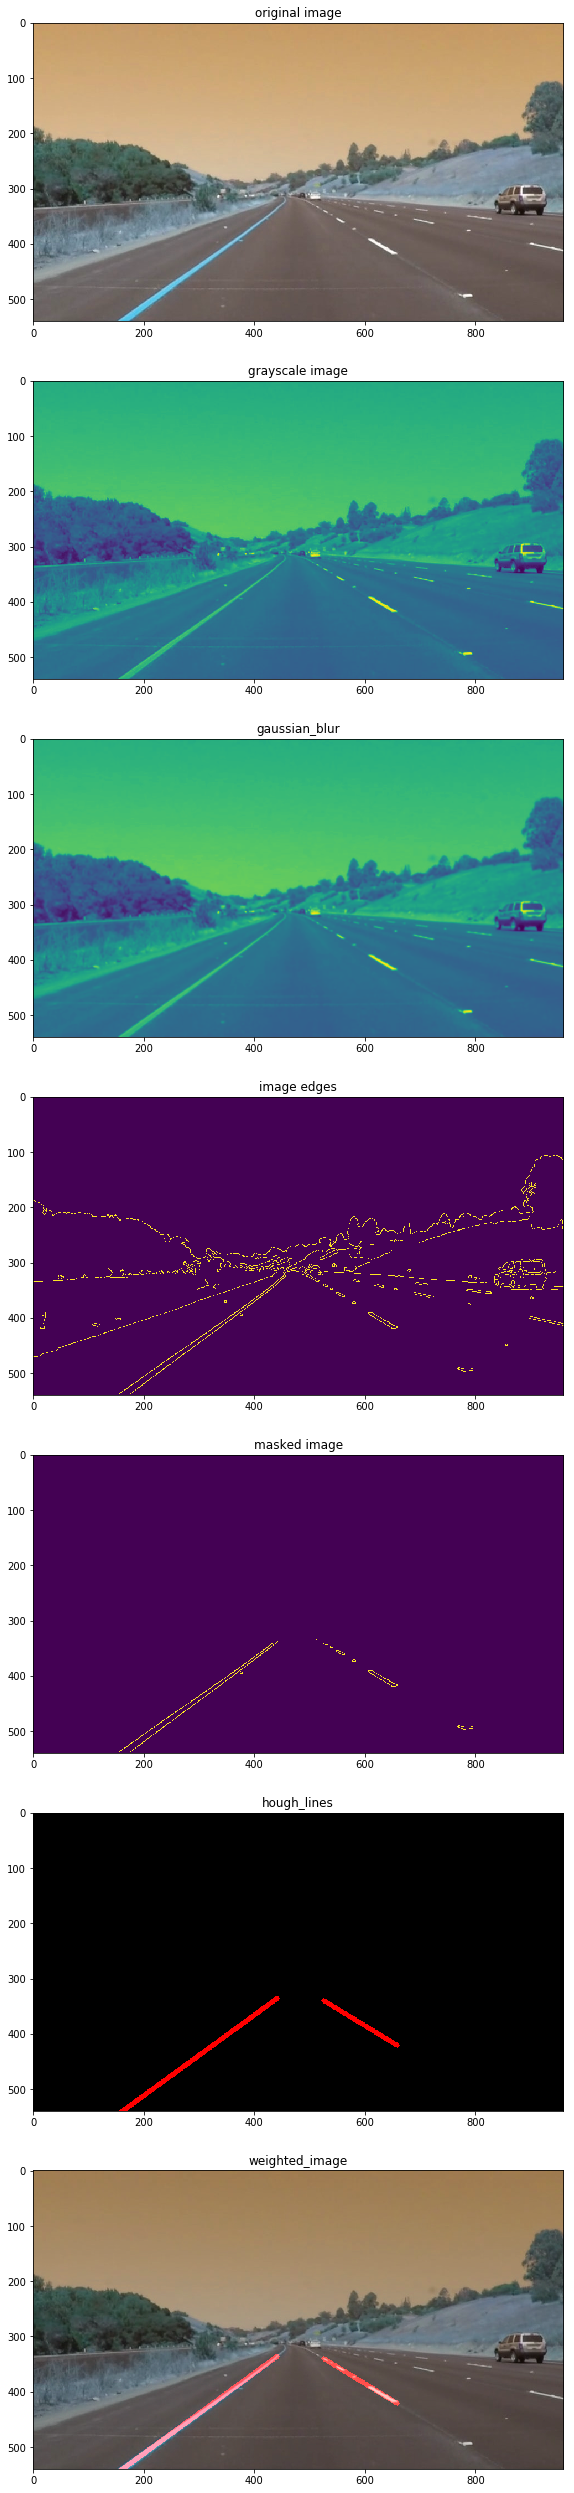

In [12]:
plt.figure(figsize=(20,10))

fig = plt.figure(figsize=(30,45))
a=fig.add_subplot(7,1,1)
img = cv2.imread('test_images/solidYellowCurve.jpg')
imgplot = plt.imshow(img)
a.set_title('original image')

a=fig.add_subplot(7,1,2)
img_gray = grayscale(img)
imgplot = plt.imshow(img_gray)
a.set_title('grayscale image')

a=fig.add_subplot(7,1,3)
img_blur = gaussian_blur(img_gray, variables['kernel_size'])
imgplot = plt.imshow(img_blur)
a.set_title('gaussian_blur')

a=fig.add_subplot(7,1,4)
img_edges = canny(img_blur, variables['low_threshold'], variables['high_threshold'])
imgplot = plt.imshow(img_edges)
a.set_title('image edges')

a=fig.add_subplot(7,1,5)
img_masked = region_of_interest(img_edges, variables['vertices'])
imgplot = plt.imshow(img_masked)
a.set_title('masked image')

a=fig.add_subplot(7,1,6)
img_lines = hough_lines(img_masked, **variables['hough'])
imgplot = plt.imshow(img_lines)
a.set_title('hough_lines')

a=fig.add_subplot(7,1,7)
img_weighted = weighted_img(img_lines, img)
imgplot = plt.imshow(img_weighted)
a.set_title('weighted_image')

In [13]:
def pipeline(img, variables):
    
    #grayscale the image
    img_gray = grayscale(img)
    
    # Define a kernel size and apply Gaussian smoothing
    
    img_blur = gaussian_blur(img_gray, variables['kernel_size'])
    
    # Define our parameters for Canny and apply
   
    img_edges = canny(img_blur, variables['low_threshold'], variables['high_threshold'])
    
    # Create a masked edges image using region_of_interest()
    img_masked = region_of_interest(img_edges, variables['vertices'])
    
    # Run Hough on edge detected image

    img_lines = hough_lines(img_masked, **variables['hough']) 
    
    # combine original image with lines
    img_weighted = weighted_img(img_lines, img)
    
    return img_weighted

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    result = pipeline(image, variables)
    return result

Let's try the one with the solid white lane on the right first ...

In [16]:
os.mkdir('test_videos_output')

NameError: name 'os' is not defined

In [17]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 29.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 14.1 s, sys: 128 ms, total: 14.3 s
Wall time: 7.31 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [69]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 44.6 s, sys: 532 ms, total: 45.1 s
Wall time: 23.3 s


In [70]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))